______
<img style="float: right;" src="./images/headerlogo.png">
## Google Earth Engine Tutorial
### Image Algebra
_____

In this notebook image algebra will be illustrated by calculating losses on NDVIs given two images acquired in different dates over the same study area. First, NDVIs will be extracted. Second, these indices will be filtered to keep only the positive values (vegetation presence). Third, the difference between positive indices is calculated and again is filtered to keep only the losses. Finally, a mask will be created to expose areas where the NDVI had losses. 

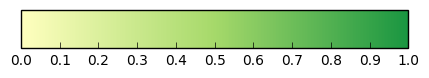

In [8]:
# Now we will like to dismiss the gaining vegetation and only take into account the losses
# Losses mean than vegetation index in jul was higher than vegetation index in nov
import ee
ee.Initialize()
from IPython.display import Image
from IPython.display import display

imgjuls = ee.Image('users/rosamaguilar/tutorial/imgjul')
imgnovs = ee.Image('users/rosamaguilar/tutorial/imgnov')

ndvijul = imgjuls.normalizedDifference(['b7', 'b5']).rename(['NDVI'])
ndvinov = imgnovs.normalizedDifference(['b7', 'b5']).rename(['NDVI'])

ndvijul_positive = ndvijul.where(ndvijul.lte(0),0)   # to keep positive values
ndvinov_positive = ndvinov.where(ndvinov.lte(0),0)   # to keep positive values
# define a palette for visualization, greenest color imply higher values
palette =','.join(['ffffbf','a6d96a','1a9641'])

img1 = Image(url =ndvijul_positive.getThumbUrl({'min': 0, 'max': 1, 'palette':palette }))
img2 = Image(url =ndvinov_positive.getThumbUrl({'min': 0, 'max': 1, 'palette':palette }))
display(img1,img2)


# create the color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm, colorbar
from matplotlib import colors as mcolors


# format the pallete 
palette = palette.split(',')
color_list = list(map(lambda x: '#'+x.strip(), palette))
# create a linear segmented colormap with the specified name from a given sequence of colors 
cmap_obj = LinearSegmentedColormap.from_list('palette', color_list)
# apply a linear normalization to the palette using min and max
cnorm = mcolors.Normalize(vmin=0, vmax=1) 
# draw a bar
fig = plt.figure(figsize=(5, 0.5))
ax = plt.subplot(111)
cbar = colorbar.ColorbarBase(ax, norm=cnorm, orientation='horizontal', cmap=cmap_obj)
plt.show();

In [5]:
# Calculate the difference
vi_diff = ndvijul_positive.subtract(ndvinov_positive)  
# create a mask 
mask = ee.Image(1).toByte().clip(vi_diff.geometry())
mask = mask.where(vi_diff.gte(0),0)  

# apply the mask to the last image (nov) 
imgnovmasked = imgnovs.mask(mask) 
# transparent pixels are areas where vegetation  had gain or remain equal
Image(url=imgnovmasked.getThumbUrl({'min': 0, 'max': 2048,'bands': 'b5,b3,b2'}))